In [1]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import jax
import matplotlib.pyplot as plt

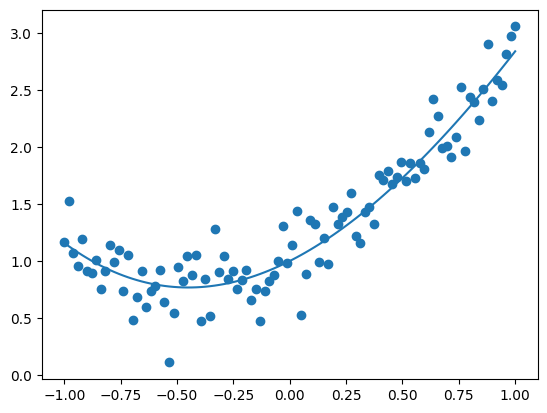

In [2]:
x_lin = torch.linspace(-1, 1, 100)  
x_axis = x_lin.numpy()
f = lambda x: x**2 + torch.sin(x) + 1
eps = torch.randn(100) * 0.2
y = f(x_lin) + eps

y = y.unsqueeze(-1)

plt.plot(x_lin, f(x_lin))
plt.scatter(x_lin, y)

In [3]:
# Add a column of ones to x_lin
x_lin = torch.stack([ torch.ones(100), x_lin], dim=1)

# Add a column of x^2 to x_lin
x_lin = torch.cat([x_lin, x_lin[:,1].unsqueeze(1)**2], dim=1)

# Add a column of x^3 to x_lin
x_lin = torch.cat([x_lin, x_lin[:,1].unsqueeze(1)**3], dim=1)

# Add a column of x^4 to x_lin
x_lin = torch.cat([x_lin, x_lin[:,1].unsqueeze(1)**4], dim=1)

In [4]:
sli = 0.2

In [5]:
import hamiltorch

def nn_forward(x , w):

    model = torch.nn.Sequential(
        torch.nn.Linear(5, 2),
        torch.nn.ReLU(),
        torch.nn.Linear(2, 1),
    )

    # param = {"params" : w}
    # y_pred = torch.func.functional_call(model, param , x)

    params_list = hamiltorch.util.unflatten(model, w)
    hamiltorch.util.update_model_params_in_place(model, params_list)
    y_pred = model(x)

    return y_pred

In [6]:
def pyro_model(x,y):
    w = pyro.sample("w", dist.Normal(0, 1).expand([15]).to_event(1))
    mean = nn_forward(x, w)
    with pyro.plate("data", x.shape[0]):
        y_pred = pyro.sample("obs", dist.Normal(mean, sli), obs=y)
    return y_pred

In [21]:
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=1000 , warmup_steps=200)
mcmc.run(x_lin, y)

Warmup:   0%|          | 0/1200 [00:00, ?it/s]

Sample: 100%|██████████| 1200/1200 [09:17,  2.15it/s, step size=2.47e-06, acc. prob=0.776]


In [22]:
samples_ = mcmc.get_samples()
samples_

{'w': tensor([[ 0.6638, -1.6170,  0.0671,  ...,  0.6166, -0.3539,  0.3304],
         [ 0.6638, -1.6170,  0.0671,  ...,  0.6166, -0.3539,  0.3304],
         [ 0.6638, -1.6170,  0.0671,  ...,  0.6166, -0.3539,  0.3304],
         ...,
         [ 0.6631, -1.6168,  0.0666,  ...,  0.6126, -0.3545,  0.3351],
         [ 0.6631, -1.6168,  0.0666,  ...,  0.6126, -0.3544,  0.3351],
         [ 0.6631, -1.6168,  0.0666,  ...,  0.6126, -0.3544,  0.3351]])}

In [23]:
w_mean = samples_['w'].mean(axis=0)
w_mean

tensor([ 0.6636, -1.6168,  0.0670, -0.7103, -0.2812, -0.7329, -0.8651, -1.9670,
         0.7254,  0.8476,  0.0076,  0.3705,  0.6147, -0.3541,  0.3329])

In [24]:
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

# Number of parameters in the model
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % n_params)

Number of parameters: 15


In [25]:
# Run the model on the data

params_list = hamiltorch.util.unflatten(model, w_mean)
hamiltorch.util.update_model_params_in_place(model, params_list)
y_pred = model(x_lin)

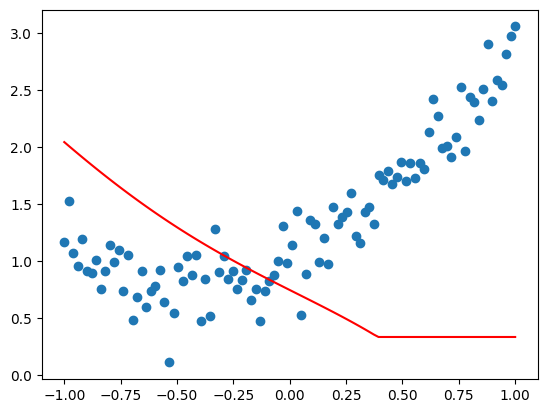

In [26]:
x_axis = x_lin[:,1]
plt.plot(x_axis, y_pred.detach().numpy() , color='red')
plt.scatter(x_axis, y)
plt.show()